# Домашнее задание №1

Для начала импортируем все нужное:

In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from copy import copy
from string import punctuation
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.svm import SVC
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

punctuation += "”’“‘"
warnings.filterwarnings('ignore')

Загрузим датасет и добавим несколько столбцов для удобства:

In [2]:
df = pd.read_csv("Shoes_Data.csv")

In [3]:
# длины описаний
df["desc_len"] = df["product_description"].apply(len)

In [4]:
# цена float
df["price_in_rupees"] = df["price"].apply(lambda x: float(x[1:]))

В итоге наш датасет выглядит вот так:

In [5]:
df.head()

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type,desc_len,price_in_rupees
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,₹279.00,2.9 out of 5 stars,2389 ratings,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men,222,279.0
1,Bourge Men's Loire-z126 Running Shoes,₹479.00,3.9 out of 5 stars,11520 ratings,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men,78,479.0
2,T-Rock Men's Sneaker,₹430.00,3.3 out of 5 stars,1251 ratings,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men,398,430.0
3,Robbie jones Sneakers Casual Canvas Fabric Col...,₹499.00,4.2 out of 5 stars,3 ratings,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men,576,499.0
4,Sparx Men's Sd0323g Sneakers,₹499.00,4.2 out of 5 stars,20110 ratings,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men,1030,499.0


В качестве токенайзера воспользуемся TweetTokenizer, предназначенного как раз для токенизации текстов из интернета. Все тексты очистим от стоп-слов, однако оставим слова "no" и "not", т.к. мы увидели, что они часто встречаются в негативных отзывах (см. ячейку выше). Чтобы избавиться от иностранных слов, воспользуемся регулярными выражениями (не будем принимать токены, которые не содержат латинских букв).

In [6]:
tw = TweetTokenizer()
eng_stopwords = stopwords.words("english")
eng_stopwords.remove("no")
eng_stopwords.remove("not")

def preprocess(text):
    text_tokenized = tw.tokenize(text.lower())
    text_tokenized_clean = []
    for token in text_tokenized:
        if not re.match("[^a-zA-Z]", token) and token not in eng_stopwords:
            text_tokenized_clean.append(token)
    return text_tokenized_clean

Проверим, что у нас нет нулевых значений в таблице:

In [7]:
df.isnull().sum()

title                  0
price                  0
rating                 0
total_reviews          0
product_description    0
reviews                0
reviews_rating         0
Shoe Type              0
desc_len               0
price_in_rupees        0
dtype: int64

Посмотрим, можно ли найти по крайней мере линейную корреляцию между длиной описания и ценой товара:

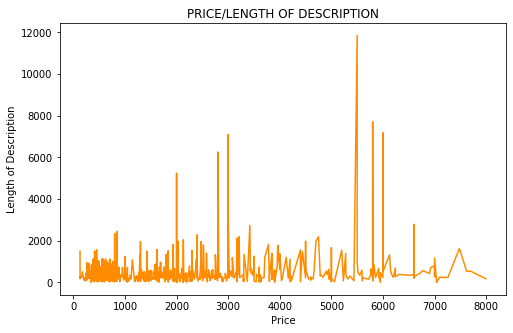

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(df.sort_values(by=["price_in_rupees"]).price_in_rupees,
         df.sort_values(by=["price_in_rupees"]).desc_len,
         color="darkorange")
plt.title('PRICE/LENGTH OF DESCRIPTION')
plt.xlabel('Price')
plt.ylabel('Length of Description')
plt.show()

In [9]:
df["desc_len"].corr(df["price_in_rupees"])

0.16737861898587486

Оказывается, что нет.

## Классификация

К сожалению, отзывы устроены так, что для них придется создать еще один датасет.

In [10]:
df_reviews = pd.DataFrame({"text": [], "rating": []})

Сделаем удобно для машины и конвертируем рейтинги в числа:

In [11]:
le = LabelEncoder()
le.fit(["1.0 out of 5 stars",
        "2.0 out of 5 stars",
        "3.0 out of 5 stars",
        "4.0 out of 5 stars",
        "5.0 out of 5 stars"])

LabelEncoder()

Каждое значение столбцов *review* и *reviews_rating* нужно разделить и полученные строчки добавить в наш новый датасет:

In [12]:
for i, review in enumerate(df.reviews):
    texts_split = review.split("|| ")
    marks_split = df.reviews_rating[i].split("|| ")
    mini_df = pd.DataFrame({"text": texts_split, "rating": le.transform(marks_split)})
    df_reviews = pd.concat([df_reviews, mini_df], ignore_index=True)

Получаем такой датасет:

In [13]:
df_reviews.head()

,text,rating
0,Not happy with product,0.0
1,It's not as expected.,0.0
2,AVERAGE PRODUCT,2.0
3,Pic more beautiful,2.0
4,Got damage product. But quality is average for...,2.0


Посмотрим, есть ли разница в длине отзыва в зависимости от рейтинга. Для начала для каждого рейтинга подсчитаем среднюю длину.

In [14]:
len_sum_by_rating = np.zeros(5)
for review in df_reviews.values:
    len_sum_by_rating[int(review[1])] += len(review[0])
reviews_count_by_rating = np.array([len(df_reviews[df_reviews.rating == i]) for i in range(5)])
avg_len_by_rating = np.divide(len_sum_by_rating, reviews_count_by_rating)

Теперь построим график:

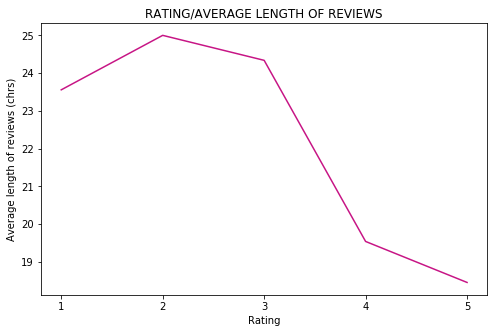

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, 6, 1),
        avg_len_by_rating,
        color="mediumvioletred")
plt.xticks(np.arange(1, 6, 1))
plt.title('RATING/AVERAGE LENGTH OF REVIEWS')
plt.xlabel('Rating')
plt.ylabel('Average length of reviews (chrs)')
plt.show()

Интересным образом, мы видим что небольшая зависимость между длиной отзыва и оценкой есть: чем хуже отзыв, тем длиннее текст (хоть и не совсем). Однако разница небольшая, средняя длина отзыва 2/5 больше длины отзыва 5/5 всего на:

In [16]:
avg_len_by_rating[1]-avg_len_by_rating[-1]

6.546725511521391

символов.

Посмотрим, какие отзывы повторяются в каждой категории:

In [17]:
print("VALUE COUNTS\n")
for i in range(5):
    print(f"RATED {i+1} OUT OF 5 STARS:")
    print(df_reviews.groupby("rating").text.value_counts()[i][:5])
    print()

VALUE COUNTS

RATED 1 OUT OF 5 STARS:
text
Verified Purchase    67
Report abuse         30
Poor quality         29
Fake product         21
Fake                 18
Name: text, dtype: int64

RATED 2 OUT OF 5 STARS:
text
Verified Purchase    26
Report abuse         17
Not comfortable      11
Not good              8
Good                  6
Name: text, dtype: int64

RATED 3 OUT OF 5 STARS:
text
Verified Purchase    46
Report abuse         26
Good                 18
Good product         11
Ok                   11
Name: text, dtype: int64

RATED 4 OUT OF 5 STARS:
text
Verified Purchase    118
Good                 108
Report abuse          59
Good product          49
Nice                  34
Name: text, dtype: int64

RATED 5 OUT OF 5 STARS:
text
Verified Purchase    444
Report abuse         307
Good                 140
Good product          66
Nice                  63
Name: text, dtype: int64



Мы видим, что везде постоянно встречаются комментарии "Verified Purchase" и "Report abuse", скорее всего это варианты, которые можно оставить автоматически. При препроцессинге мы учтем, что от них нужно избавиться, поскольку они никак не соотносятся с рейтингом.

Препроцессим тексты и рейтинги (избавляемся от тех, которые соответствуют комментариям "Verified Purchase" и "Report Abuse".

In [18]:
reviews_processed = [" ".join(preprocess(text)) for text in df_reviews.text if text not in ("Verified Purchase",
                                                                                           "Report abuse")]

In [19]:
ratings = [rating for i, rating in enumerate(df_reviews.rating) if df_reviews.text[i] not in ("Verified Purchase",
                                                                                           "Report abuse")]

Создаем датасет, в котором токенизированные тексты:

In [20]:
df_reviews_tokenized = pd.DataFrame({"text": reviews_processed, "rating": ratings})

In [21]:
df_reviews_tokenized.head()

,text,rating
0,not happy product,0.0
1,not expected,0.0
2,average product,2.0
3,pic beautiful,2.0
4,got damage product quality average,2.0


Проверим, что у нас нет нулевых данных:

In [22]:
df_reviews_tokenized.isnull().sum()

text      0
rating    0
dtype: int64

Посмотрим, какие теперь частотные отзывы:

In [23]:
print("VALUE COUNTS\n")
for i in range(5):
    print(f"RATED {i+1} OUT OF 5 STARS:")
    print(df_reviews_tokenized.groupby("rating").text.value_counts()[i][:5])
    print()

VALUE COUNTS

RATED 1 OUT OF 5 STARS:
text
poor quality    39
fake product    33
bad quality     23
not good        23
waste money     22
Name: text, dtype: int64

RATED 2 OUT OF 5 STARS:
text
not comfortable    16
not good           16
poor quality        8
good                7
                    6
Name: text, dtype: int64

RATED 3 OUT OF 5 STARS:
text
good               24
ok                 19
good product       15
average            11
not comfortable     8
Name: text, dtype: int64

RATED 4 OUT OF 5 STARS:
text
good            134
good product     71
nice             46
value money      40
nice product     34
Name: text, dtype: int64

RATED 5 OUT OF 5 STARS:
text
good            212
good product    118
nice            109
value money      82
comfortable      79
Name: text, dtype: int64



На этот раз они больше соответствуют своим оценкам.

Если для каждого рейтинга составить вордклауд, то получатся примерно такие:

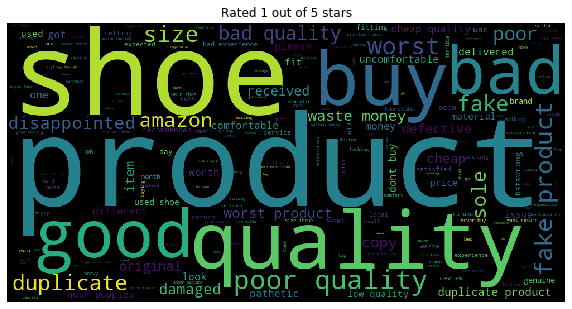

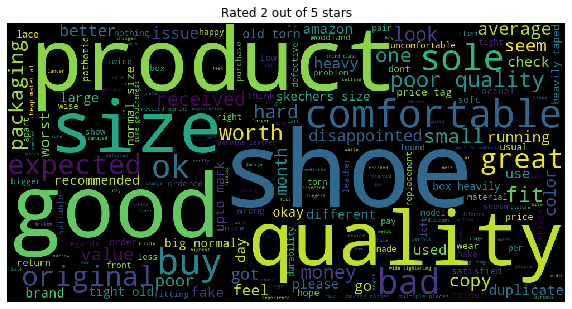

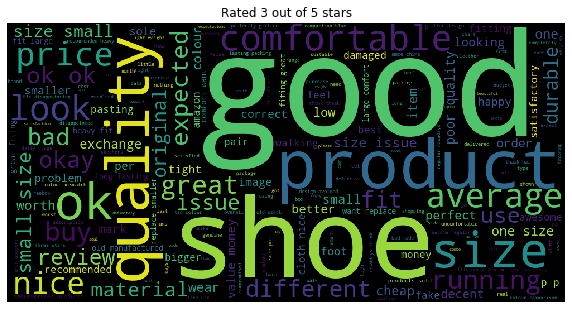

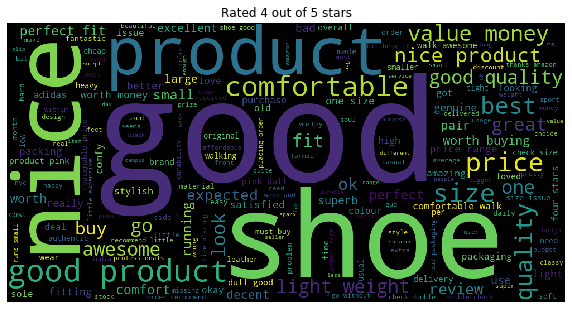

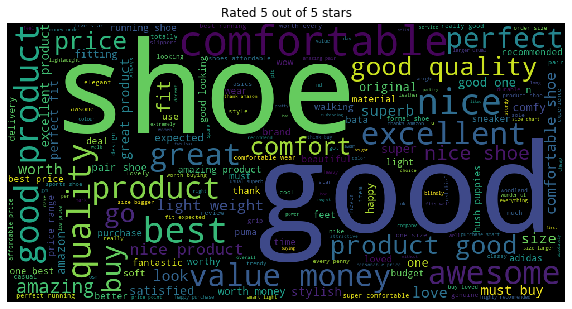

In [24]:
rating_group = df_reviews_tokenized.groupby('rating')

for rating in rating_group:
    wordcloud = WordCloud(width=1000, height=500).generate(" ".join(rating[1].text))
    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud)
    plt.title(f"Rated {int(rating[0])+1} out of 5 stars")
    plt.axis("off")
    plt.show()

Несмотря на то, что мы убрали некоторые отзывы, все равно есть слова, которые встречаются часто во всех категориях: shoe, quality, product. Поэтому может быть логично в нашем пайплайне использовать tf-idf или ограничение max_df.

Но есть и некоторые слова, которые более свойственны отрицательным/положительным отзывам: bad, poor, worst; awesome, comfortable, nice.

Посмотрим, сбалансированная ли у нас выборка:

In [25]:
df_reviews_tokenized.rating.value_counts()

4.0    4193
3.0    1676
0.0    1652
2.0     791
1.0     506
Name: rating, dtype: int64

Нет. Вот более наглядно. Отзывов с 5 звездами гораздо больше, чем остальных.

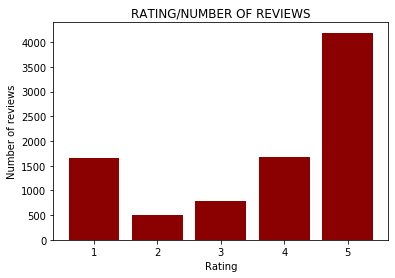

In [26]:
rating_count = df_reviews_tokenized.groupby('rating').count()
plt.bar([1, 2, 3, 4, 5], rating_count['text'], color="darkred")
plt.title("RATING/NUMBER OF REVIEWS")
plt.xlabel('Rating')
plt.ylabel('Number of reviews')
plt.show()

Делим на train и test выборку:

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_reviews_tokenized.text,
                                                    df_reviews_tokenized.rating,
                                                    random_state=42)

Пытаемся ее сбалансировать, продублировав отзывы категорий, которых мало:

In [28]:
oversampler = RandomOverSampler(random_state=42)
X_train, y_train = oversampler.fit_resample(np.array(X_train).reshape(-1, 1), y_train)

Перенастраиваем X_train так, чтобы скормить его модели:

In [29]:
X_train = pd.Series(np.reshape(X_train, len(X_train)))

Пишем сетку гиперпараметров для пайплайна с классификатором SVM.

In [30]:
SVM_parameters = {'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
                  'tfidf__use_idf': [True, False],
                  'svc__kernel':('linear', 'rbf'),
                  'svc__C': [1, 5, 10]}

Пишем пайплайн:

In [31]:
SVM_classifier = Pipeline([('vect', CountVectorizer()),
                           ('tfidf', TfidfTransformer(use_idf=True)),
                           ('svc', SVC(class_weight="balanced"))])

Гридсерч:

In [32]:
SVM_gridsearch = GridSearchCV(SVM_classifier,
                              SVM_parameters,
                              n_jobs=-1,
                              scoring="f1_macro")

Запускаем:

In [33]:
SVM_gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('svc', SVC(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'svc__C': [1, 5, 10], 'svc__kernel': ('linear', 'rbf'),
                         'tfidf__use_idf': [True, False],
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             scoring='f1_macro')

Посмотрим на лучшую F1-меру и гиперпараметры, которые ей соответствуют.

In [34]:
SVM_gridsearch.best_score_

0.8134054764278181

In [35]:
SVM_gridsearch.best_params_

{'svc__C': 5,
 'svc__kernel': 'rbf',
 'tfidf__use_idf': False,
 'vect__ngram_range': (1, 2)}

Получается, что лучшая модель такая:

In [36]:
SVM_gridsearch.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('svc', SVC(C=5, class_weight='balanced'))])

Попробуем сделать то же самое с наивным байесовским классификатором:

In [37]:
NB_parameters = {'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
                 'tfidf__use_idf': [True, False],
                 'nb__alpha': [1.0, 0.75, 0.5, 0.25, 0]}

In [38]:
NB_classifier = Pipeline([('vect', CountVectorizer()),
                           ('tfidf', TfidfTransformer(use_idf=True)),
                           ('nb', MultinomialNB())])

In [39]:
NB_gridsearch = GridSearchCV(NB_classifier,
                             NB_parameters,
                             n_jobs=-1,
                             scoring="f1_macro")

In [40]:
NB_gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'nb__alpha': [1.0, 0.75, 0.5, 0.25, 0],
                         'tfidf__use_idf': [True, False],
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             scoring='f1_macro')

In [41]:
NB_gridsearch.best_score_

0.7653421482553997

В итоге модель SVM оказалась лучше.

Cтроим модель, тренируем и просим ее предсказать ответы:

In [42]:
classifier = SVM_gridsearch.best_estimator_
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

Что она угадывает хорошо, а что – плохо?

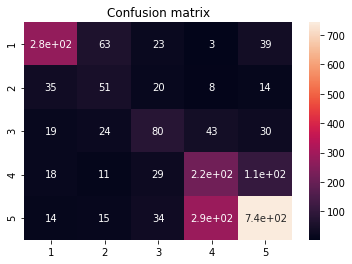

In [43]:
sns.heatmap(data=confusion_matrix(y_test, predictions),
            annot=True,
            xticklabels=[1, 2, 3, 4, 5],
            yticklabels=[1, 2, 3, 4, 5])
plt.title("Confusion matrix")
plt.show()

Вполне ожидаемые результаты: хорошо угадываются худшие и лучшие оценки, а уже 2 и 4 звезды путаются с крайними случаями.

Метрики показывают результаты значительно хуже, чем те, которые мы получили при гридсерче (что тоже ожидаемо):

In [44]:
acc = accuracy_score(predictions, y_test)
micro_f1 = f1_score(predictions, y_test, average='micro')
micro_precision = precision_score(predictions, y_test, average='micro')
micro_recall = recall_score(predictions, y_test, average='micro')
macro_f1 = f1_score(predictions, y_test, average='macro')
macro_precision = precision_score(predictions, y_test, average='macro')
macro_recall = recall_score(predictions, y_test, average='macro')
weighted_f1 = f1_score(predictions, y_test, average='weighted')
weighted_precision = precision_score(predictions, y_test, average='weighted')
weighted_recall = recall_score(predictions, y_test, average='weighted')

print(f"ACCURACY: {acc:.4f}")
print("\nMICRO-")
print(f"F1-SCORE: {micro_f1:.4f}\tPRECISION: {micro_precision:.4f}\tRECALL: {micro_recall:.4f}")
print("\nMACRO-")
print(f"F1-SCORE: {macro_f1:.4f}\tPRECISION: {macro_precision:.4f}\tRECALL: {macro_recall:.4f}")
print("\nWEIGHTED")
print(f"F1-SCORE: {weighted_f1:.4f}\tPRECISION: {weighted_precision:.4f}\tRECALL: {weighted_recall:.4f}")

ACCURACY: 0.6195

MICRO-
F1-SCORE: 0.6195	PRECISION: 0.6195	RECALL: 0.6195

MACRO-
F1-SCORE: 0.5361	PRECISION: 0.5468	RECALL: 0.5371

WEIGHTED
F1-SCORE: 0.6062	PRECISION: 0.6070	RECALL: 0.6195


Чтобы продемонстрировать работу модели, попросим ее предсказать рейтинг по нескольким текстам.

In [45]:
classifier.predict(["incredible shoes",
                    "average shoes",
                    "terrible shoes",
                    "hate them",
                    "love them",
                    "not happy"])

array([4., 2., 0., 0., 4., 2.])

Если вспомнить, что каждое значение нужно увеличить на 1, чтобы получить предсказываемое кол-во звезд, то предсказания выглядят вполне правдоподобно.

## Регрессия

Добавим предобработанные описания товаров в виде дополнительного столбца.

In [46]:
product_descs_processed = [" ".join(preprocess(text)) for text in df.product_description]
df["product_description_tokenized"] = product_descs_processed

In [47]:
df.head()

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type,desc_len,price_in_rupees,product_description_tokenized
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,₹279.00,2.9 out of 5 stars,2389 ratings,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men,222,279.0,elevate style classy pair running shoe house c...
1,Bourge Men's Loire-z126 Running Shoes,₹479.00,3.9 out of 5 stars,11520 ratings,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men,78,479.0,product excellent pick ensures easy maintenance
2,T-Rock Men's Sneaker,₹430.00,3.3 out of 5 stars,1251 ratings,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men,398,430.0,flaunt stylish unique red casual shoes per lat...
3,Robbie jones Sneakers Casual Canvas Fabric Col...,₹499.00,4.2 out of 5 stars,3 ratings,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men,576,499.0,robbie jones shoes designed keeping mind durab...
4,Sparx Men's Sd0323g Sneakers,₹499.00,4.2 out of 5 stars,20110 ratings,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men,1030,499.0,sparx spectacular range footwear house relaxo ...


Вот такие слова часто употребляются в описаниях:

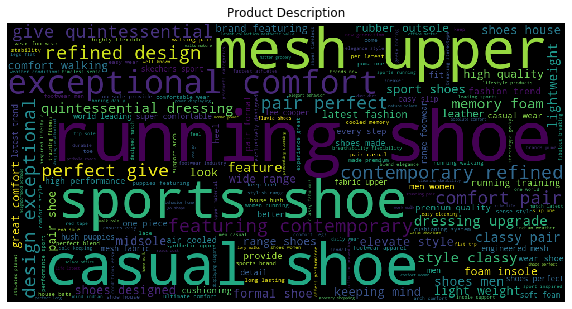

In [48]:
wordcloud = WordCloud(width=1000, height=500).generate(" ".join(df.product_description_tokenized))
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.title("Product Description")
plt.axis("off")
plt.show()

Разделим выборку на тренировочную и тестовую и опробуем несколько пайплайнов: обычную регрессию, р. с регуляризатором Ridge и регрессию с регуляризатором Lasso.

In [49]:
X_desc_train, X_desc_test, y_desc_train, y_desc_test = train_test_split(df.product_description_tokenized,
                                                                        df.price_in_rupees,
                                                                        random_state=42)

In [50]:
LinReg_parameters = {"reg__fit_intercept": [True, False],
                     "tfidf__use_idf": [True, False]}

In [51]:
LinReg_pipeline = Pipeline([("vect", CountVectorizer()),
                            ("tfidf", TfidfTransformer(use_idf=True)),
                            ("reg", LinearRegression())])
LinReg_gridsearch = GridSearchCV(LinReg_pipeline,
                                 param_grid=LinReg_parameters,
                                 n_jobs=-1,
                                 scoring="neg_mean_absolute_error")
LinReg_gridsearch.fit(X_desc_train, y_desc_train)
print(f"BEST SCORE:\t{LinReg_gridsearch.best_score_}")

BEST SCORE:	-828.2887891785497


Добавим несколько гиперпараметров для Ridge и Lasso.

In [52]:
LinReg_parameters["reg__alpha"] = [1.0, 0.1, 0.01, 0.001, 0.0001]

Ridge_parameters = copy(LinReg_parameters)
Ridge_parameters["reg__solver"] = ['sparse_cg', 'sag']

In [53]:
Ridge_pipeline = Pipeline([("vect", CountVectorizer()),
                            ("tfidf", TfidfTransformer(use_idf=True)),
                            ("reg", Ridge())])
Ridge_gridsearch = GridSearchCV(Ridge_pipeline,
                                 param_grid=Ridge_parameters,
                                 n_jobs=-1,
                                 scoring="neg_mean_absolute_error")
Ridge_gridsearch.fit(X_desc_train, y_desc_train)
print(f"BEST SCORE:\t{Ridge_gridsearch.best_score_}")

BEST SCORE:	-628.7137454276384


In [54]:
Lasso_pipeline = Pipeline([("vect", CountVectorizer()),
                            ("tfidf", TfidfTransformer(use_idf=True)),
                            ("reg", Lasso())])
Lasso_gridsearch = GridSearchCV(Lasso_pipeline,
                                 param_grid=LinReg_parameters,
                                 n_jobs=-1,
                                 scoring="neg_mean_absolute_error")
Lasso_gridsearch.fit(X_desc_train, y_desc_train)
print(f"BEST SCORE:\t{Lasso_gridsearch.best_score_}")

BEST SCORE:	-676.6126295328362


Продублируем сюда:

In [55]:
print(f"LINREG:\t{LinReg_gridsearch.best_score_}")
print(f"RIDGE:\t{Ridge_gridsearch.best_score_}")
print(f"LASSO:\t{Lasso_gridsearch.best_score_}")

LINREG:	-828.2887891785497
RIDGE:	-628.7137454276384
LASSO:	-676.6126295328362


Получается, среди моделей лучше всего выбирать Ridge.

In [56]:
regressor = Ridge_gridsearch.best_estimator_
regressor.fit(X_desc_train, y_desc_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('reg', Ridge(alpha=0.1, solver='sag'))])

In [57]:
price_predictions = regressor.predict(X_desc_test)

Интересным образом, MAE на тестовой выборке получилась ниже:

In [58]:
MAE = mean_absolute_error(price_predictions, y_desc_test)
RMSE = np.sqrt(mean_squared_error(price_predictions, y_desc_test))
R2 = r2_score(y_desc_test, price_predictions)
print(f"MAE:\t{MAE}")
print(f"RMSE:\t{RMSE}")
print(f"R2:\t{R2}")

MAE:	579.4218065800173
RMSE:	883.3181874501483
R2:	0.7151899710181711


Посмотрим, какие токены в описании по мнению модели должны завышать и занижать цену товара.

Самые большие веса оказываются у следующих токенов:

In [59]:
sorted(list(zip(regressor.named_steps["vect"].get_feature_names(),
                regressor.named_steps["reg"].coef_)),
       key=lambda x: x[1])[:-6:-1]

[('nike', 4803.4170442747),
 ('adidas', 4609.429347846957),
 ('badminton', 4258.700949845908),
 ('boots', 3828.0541426732916),
 ('trail', 2981.200345092781)]

Самые маленькие (идущие в минус => занижающие цену) веса:

In [60]:
sorted(list(zip(regressor.named_steps["vect"].get_feature_names(),
                regressor.named_steps["reg"].coef_)),
       key=lambda x: x[1])[:5]

[('coolest', -2906.8893486131064),
 ('dual', -2497.86505517607),
 ('lightweight', -2270.741027130359),
 ('arrow', -2086.723095891276),
 ('nivia', -2009.759607483967)]

Посмотрим, насколько эти токены частотны:

In [61]:
cv = CountVectorizer()
cv_fit = cv.fit_transform(X_desc_train)
for token in ["nike", "adidas", "badminton", "boots", "trail"]:
    token_ix = cv.get_feature_names().index(token)
    print(f"{token}:\t{cv_fit.toarray().sum(axis=0)[token_ix]}")

nike:	98
adidas:	53
badminton:	9
boots:	11
trail:	9


In [62]:
for token in ["coolest", "dual", "lightweight", "arrow", "nivia"]:
    token_ix = cv.get_feature_names().index(token)
    print(f"{token}:\t{cv_fit.toarray().sum(axis=0)[token_ix]}")

coolest:	2
dual:	24
lightweight:	232
arrow:	2
nivia:	4


Мы видим, что некоторые токены, которым модель дает очень большие веса по модулю, оказываются очень редки в корпусе, что явно минус: недостаточно данных для того, чтобы подобный токен так сильно влиял на предсказание.

По крайней мере _nike_ и _adidas_ можно проинтерпретировать: крупные бренды обычно стоят дороже.

Давайте посмотрим на распределение цен тренировочной выборки.

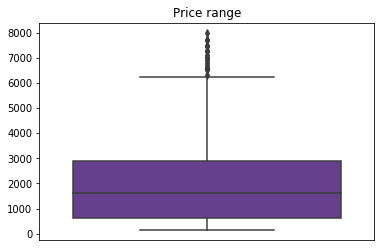

In [63]:
sns.boxplot(data=y_desc_train, color="rebeccapurple")
plt.title("Price range")
plt.xticks([])
plt.show()

Мы видим, что есть много слишком дорогих выбросов. Возможно, избавление от них в выборке поможет улучшить качество модели. Проверим и создадим датафрейм, чтобы его отфильтровать:

In [64]:
df_filtered = pd.DataFrame({"product_description_tokenized": X_desc_train,
                            "price_in_rupees": y_desc_train})

Отфильтруем, руководствуясь определением выбросов:

In [65]:
Q1 = y_desc_train.quantile(0.25)
Q3 = y_desc_train.quantile(0.75)
IQR = Q3 - Q1

df_filtered = df_filtered.query('(@Q1 - 1.5 * @IQR) <= price_in_rupees <= (@Q3 + 1.5 * @IQR)')

В итоге разброс цен в тренировочной выборке получается такой:

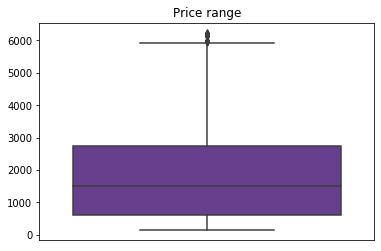

In [66]:
sns.boxplot(data=df_filtered["price_in_rupees"], color="rebeccapurple")
plt.title("Price range")
plt.xticks([])
plt.show()

Делаем гридсерч и выбираем лучший вариант.

In [67]:
Ridge_gridsearch_filtered = GridSearchCV(Ridge_pipeline,
                                         param_grid=Ridge_parameters,
                                         n_jobs=-1,
                                         scoring="neg_mean_absolute_error")
Ridge_gridsearch_filtered.fit(df_filtered.product_description_tokenized,
                              df_filtered.price_in_rupees)

regressor_filtered = Ridge_gridsearch_filtered.best_estimator_
regressor_filtered.fit(df_filtered.product_description_tokenized,
                       df_filtered.price_in_rupees)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('reg', Ridge(alpha=0.1, solver='sag'))])

Смотрим на той же выборке.

In [68]:
price_predictions_filtered = regressor_filtered.predict(X_desc_test)

In [69]:
MAE = mean_absolute_error(price_predictions_filtered, y_desc_test)
RMSE = np.sqrt(mean_squared_error(price_predictions_filtered, y_desc_test))
R2 = r2_score(y_desc_test, price_predictions_filtered)
print(f"MAE:\t{MAE}")
print(f"RMSE:\t{RMSE}")
print(f"R2:\t{R2}")

MAE:	598.1892209178154
RMSE:	1009.6467076054332
R2:	0.6278998889995783


Все оказалось хуже. Поэтому лучший вариант из рассмотренных – Ridge с такими параметрами:

In [70]:
Ridge_gridsearch.best_params_

{'reg__alpha': 0.1,
 'reg__fit_intercept': True,
 'reg__solver': 'sag',
 'tfidf__use_idf': True}

обученный на выборке вместе с изначальными выбросами.

_made by nejenek_